In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
import gc

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# device = torch.device('cpu')
print('Using PyTorch version:', torch.__version__, ' Device:', device)

Using PyTorch version: 1.7.0  Device: cuda


In [2]:
TRAIN_DATA_PATH = './train'
TEST_DATA_PATH = './test'
BATCH_SIZE = 64
VAL_SIZE = 0.2
RANDOM_SEED = 42

In [3]:
train = np.load(TRAIN_DATA_PATH + '/train.npy', allow_pickle=True)

In [4]:
target = train[:, 1]
train = train[:, 0]

In [5]:
preproc = transforms.Compose([transforms.Resize((64, 64)),
                             transforms.Normalize(mean=0, std=255)])
for i in range(train.shape[0]):
    train[i] = torch.from_numpy(train[i]).type('torch.FloatTensor')
    train[i] = 1-preproc(train[i].unsqueeze(0))
train = torch.stack(list(train))
data_mean = torch.mean(train)
data_std = torch.std(train)

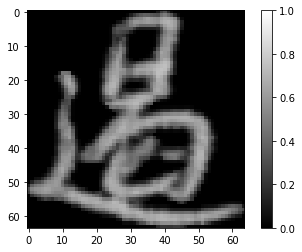

In [6]:
plt.imshow(train[1][0], cmap='gray')
plt.colorbar()
plt.clim(0, 1)
plt.show()

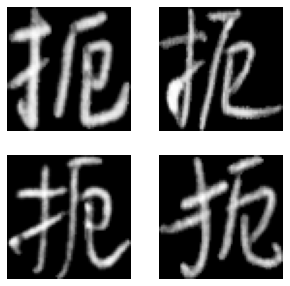

In [7]:
plt.figure(figsize=(5, 5))
j = 1
for i in range(train.shape[0]):
    if target[i] == target[0]:
        plt.subplot(2, 2, j)
        plt.imshow(train[i][0], cmap='gray')
        plt.axis('off')
        j += 1
        if j == 5:
            break

In [8]:
len(np.unique(target))

500

In [9]:
target2idx = dict(zip(sorted(np.unique(target)), np.arange(500)))
idx2target = dict((v,k) for k,v in target2idx.items())
target_norm = np.vectorize(target2idx.get)(target)

In [10]:
class ChineseDataset(torch.utils.data.Dataset):
    def __init__(self, samples, targets=None):
        self.samples = samples
        self.targets = targets

    def __len__(self):
        return self.samples.shape[0]

    def __getitem__(self, idx):
        if self.targets is not None:
            dct = {
                'x' : self.samples[idx, :],
                'y' : torch.tensor(self.targets[idx], dtype=torch.long)            
            }
        else:
            dct = {
                'x' : self.samples[idx, :]     
            }  
        return dct

In [11]:
class ChineseDataset2(torch.utils.data.Dataset):
    def __init__(self, samples, targets=None, transform = transforms.Compose([transforms.Normalize(mean=(data_mean,), std=(data_mean,))])):
        self.samples = samples
        self.targets = targets
        self.transform = transform

    def __len__(self):
        return self.samples.shape[0]

    def __getitem__(self, idx):
        if self.targets is not None:
            dct = {
                'x' : self.transform(self.samples[idx, :]),
                'y' : torch.tensor(self.targets[idx], dtype=torch.long)            
            }
        else:
            dct = {
                'x' : self.transform(self.samples[idx, :])      
            }  
        return dct

In [12]:
from sklearn.model_selection import train_test_split

train, val, target_train, target_val = train_test_split(train, target_norm, test_size=0.2, random_state=RANDOM_SEED)

In [13]:
val_dataset = ChineseDataset2(val, target_val)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
del val, target_val

In [14]:
gc.collect()

54

In [15]:
len(train)

133366

In [16]:
class RandomGaussianBlur:
    def __init__(self, kernel=3, p=0.5):
        self.kernel = kernel
        self.p = p
    
    def __call__(self, x):
        if torch.rand(1) < self.p:
            return transforms.GaussianBlur(kernel_size=self.kernel)(x)
        else:
            return x

In [17]:
from scipy.ndimage.filters import gaussian_filter
from scipy.ndimage.interpolation import map_coordinates

def elastic_transform(image, alpha_range, sigma, random_state=None):
    image = image.numpy()
    if random_state is None:
        random_state = np.random.RandomState(None)
        
    if np.isscalar(alpha_range):
        alpha = alpha_range
    else:
        alpha = np.random.uniform(low=alpha_range[0], high=alpha_range[1])

    shape = image.shape
    dx = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma) * alpha
    dy = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma) * alpha

    x, y, z = np.meshgrid(np.arange(shape[0]), np.arange(shape[1]), np.arange(shape[2]), indexing='ij')
    indices = np.reshape(x+dx, (-1, 1)), np.reshape(y+dy, (-1, 1)), np.reshape(z, (-1, 1))

    return map_coordinates(image, indices, order=1, mode='reflect').reshape(shape)

class ElasticDistortion:
    def __init__(self, alpha_range, sigma, p=0.5):
        self.alpha_range = alpha_range
        self.sigma = sigma
        self.p = p
    
    def __call__(self, x):
        if torch.rand(1) < self.p:
            return torch.from_numpy(elastic_transform(x, self.alpha_range, self.sigma)).type('torch.FloatTensor')
        else:
            return x

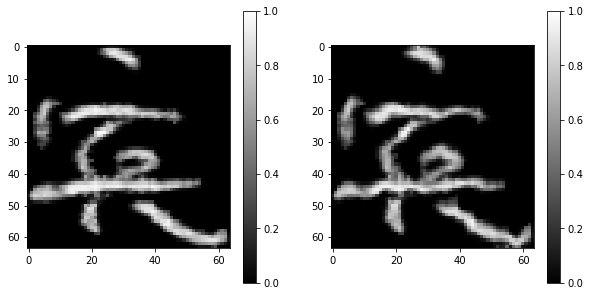

In [18]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(train[1][0], cmap='gray')
plt.colorbar()
plt.clim(0, 1)

plt.subplot(1, 2, 2)
plt.imshow(elastic_transform(train[1], 8, 2)[0], cmap='gray')
plt.colorbar()
plt.clim(0, 1)
plt.show()

In [19]:
affine = transforms.RandomAffine(degrees=25, translate=(0.1, 0.1), scale=(0.95, 1.05), fillcolor=0)

transform_train = transforms.Compose(
    [affine,
     transforms.Normalize(mean=(data_mean,), std=(data_std,))
    ])

In [20]:
el_dist = ElasticDistortion(8, 3, p=0.75)
for i in range(train.shape[0]):
    train[i] = el_dist(train[i])
# for i in range(val.shape[0]):
#     val[i] = 1 - TRANSFORM_IMG(val[i])

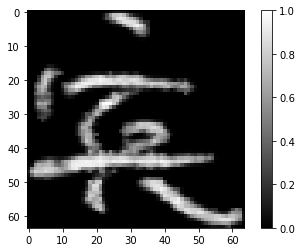

In [21]:
plt.imshow(train[1][0], cmap='gray')
plt.colorbar()
plt.clim(0, 1)

In [22]:
# np.random.seed(RANDOM_SEED)
# el_idx = list(np.random.choice(range(train.shape[0]), 100000, replace=False))

In [23]:
# target_train = np.concatenate((target_train, target_train[affine_idx]))
# for i in range(len(train[affine_idx])):
#     train = torch.cat((train, transform_train(train[affine_idx][i]).unsqueeze(0)), 0)

In [24]:
# np.random.seed(RANDOM_SEED)
# el_idx = list(np.random.choice(range(train.shape[0]), 60000, replace=False))
# target_train = np.concatenate((target_train, target_train[el_idx]))
# train = torch.cat((train, el_dist(train[el_idx])), 0)

In [25]:
assert len(train) == len(target_train)

### CNN

In [26]:
class CNN1(nn.Module):
    def __init__(self):
        super(CNN1, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32), 
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.AvgPool2d(2)

        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64), 
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.AvgPool2d(2)
        )
        
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.AvgPool2d(2)
        )

            
        self.linear1 = nn.Linear(128*8*8, 1024)
        self.linear2 = nn.Linear(1024, 500)
        

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.linear1(x))
        x = self.linear2(x)
        return F.log_softmax(x, dim=1)

## ResNET

In [59]:
from torchvision.models.resnet import ResNet, BasicBlock, Bottleneck

class MyResNet(ResNet):
    def __init__(self):
#         super(MyResNet, self).__init__(BasicBlock, [2, 2, 2, 2], num_classes=500) # Based on ResNet18
        super(MyResNet, self).__init__(BasicBlock, [3, 4, 6, 3], num_classes=500) # Based on ResNet34
#         super(MyResNet, self).__init__(Bottleneck, [3, 4, 6, 3], num_classes=500) # Based on ResNet50
        self.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=1, padding=3, bias=False)

model = MyResNet().to(device)
# print(model)

In [28]:
# def conv3x3(in_planes, out_planes, stride=1):
#     """3x3 convolution with padding"""
#     return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
#                      padding=1, bias=False)


# def conv1x1(in_planes, out_planes, stride=1):
#     """1x1 convolution"""
#     return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)

# class BasicBlock(nn.Module):
#     expansion = 1

#     def __init__(self, inplanes, planes, stride=1, downsample=None):
#         super(BasicBlock, self).__init__()
#         self.conv1 = conv3x3(inplanes, planes, stride)
#         self.bn1 = nn.BatchNorm2d(planes)
#         self.relu = nn.ReLU(inplace=True)
        
#         self.conv2 = conv3x3(planes, planes)
#         self.bn2 = nn.BatchNorm2d(planes)
#         self.downsample = downsample
#         self.stride = stride

#     def forward(self, x):
#         identity = x

#         out = self.conv1(x)
#         out = self.bn1(out)
#         out = self.relu(out)

#         out = self.conv2(out)
#         out = self.bn2(out)

#         if self.downsample is not None:
#             identity = self.downsample(x)

#         out += identity
#         out = self.relu(out)

#         return out

    
# class MyResNet(nn.Module):
#     # Based on PyTorch ResNet-18
    
#     def __init__(self, block, layers, num_classes=500, zero_init_residual=False):
#         super(MyResNet, self).__init__()
#         self.inplanes = 64
#         self.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3,
#                                bias=False)
#         self.bn1 = nn.BatchNorm2d(64)
#         self.relu = nn.ReLU(inplace=True)
#         self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
#         self.layer1 = self._make_layer(block, 64, layers[0])
#         self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
#         self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
#         self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
#         self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

#         for m in self.modules():
#             if isinstance(m, nn.Conv2d):
#                 nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
#             elif isinstance(m, nn.BatchNorm2d):
#                 nn.init.constant_(m.weight, 1)
#                 nn.init.constant_(m.bias, 0)

#         if zero_init_residual:
#             for m in self.modules():
#                 if isinstance(m, Bottleneck):
#                     nn.init.constant_(m.bn3.weight, 0)
#                 elif isinstance(m, BasicBlock):
#                     nn.init.constant_(m.bn2.weight, 0)
                    
#         self.classifier = nn.Sequential(
#             nn.Dropout(p = 0.2),
#             nn.Linear(512 * block.expansion, 256),
#             nn.BatchNorm1d(256),
#             nn.ReLU(inplace=True),
#             nn.Dropout(p = 0.2),
#             nn.Linear(256, num_classes),
#         )

#     def _make_layer(self, block, planes, blocks, stride=1):
#         downsample = None
#         if stride != 1 or self.inplanes != planes * block.expansion:
#             downsample = nn.Sequential(
#                 conv1x1(self.inplanes, planes * block.expansion, stride),
#                 nn.BatchNorm2d(planes * block.expansion),
#             )

#         layers = []
#         layers.append(block(self.inplanes, planes, stride, downsample))
#         self.inplanes = planes * block.expansion
#         for _ in range(1, blocks):
#             layers.append(block(self.inplanes, planes))

#         return nn.Sequential(*layers)

#     def forward(self, x):
#         x = self.conv1(x)
#         x = self.bn1(x)
#         x = self.relu(x)
#         x = self.maxpool(x)

#         x = self.layer1(x)
#         x = self.layer2(x)
#         x = self.layer3(x)
#         x = self.layer4(x)

#         x = self.avgpool(x)
#         x = x.view(x.size(0), -1)
#         x = self.classifier(x)

#         return F.log_softmax(x, dim=1)
# model = MyResNet(BasicBlock, [3, 4, 6, 3]).to(device)

In [29]:
class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=500):
        super().__init__()
        
        self.inplanes = 64

        self.conv1 = nn.Conv2d(1, self.inplanes, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.AvgPool2d(kernel_size=3, stride=2, padding=1)
        
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
#         self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(256 , num_classes)


    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None  
   
        if stride != 1 or self.inplanes != planes:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes, 1, stride, bias=False),
                nn.BatchNorm2d(planes),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        
        self.inplanes = planes
        
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)
    
    
    def forward(self, x):
        x = self.conv1(x)           # 64x64
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)         # 32x32

        x = self.layer1(x)          # 16x16
        x = self.layer2(x)          # 8x8
        x = self.layer3(x)          # 4x4
#         x = self.layer4(x)          # 2x2

        x = self.avgpool(x)         # 1x1
        x = torch.flatten(x, 1)     # remove 1 X 1 grid and make vector of tensor shape 
        x = self.fc(x)

        return F.log_softmax(x, dim=1)


In [30]:
# model = ResNet(BasicBlock, [3, 6, 3]).to(device)

In [31]:
# np.random.seed(RANDOM_SEED)
# val_idx = list(np.random.choice(range(train.shape[0]), round(train.shape[0] * VAL_SIZE), replace=False))
# train_idx = list(set(range(train.shape[0])) - set(val_idx))
# assert len(val_idx) + len(train_idx) == len(train)

In [32]:
train_dataset = ChineseDataset2(train, target_train, transform=transform_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
del train

c:\users\аким\appdata\local\programs\python\python37\lib\site-packages\torchvision\transforms\functional_tensor.py:876: UserWarning: Argument fill/fillcolor is not supported for Tensor input. Fill value is zero
  warnings.warn("Argument fill/fillcolor is not supported for Tensor input. Fill value is zero")


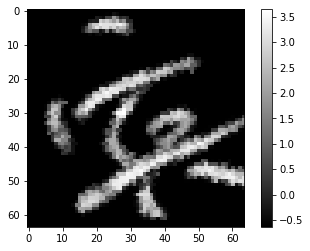

In [33]:
plt.imshow(train_dataset[1]['x'][0], cmap='gray')
plt.colorbar()

In [34]:
gc.collect()

12390

In [35]:
def accuracy_calc(model, val_loader):
    model.eval()
    correct_count, all_count = 0, 0
    for data in val_loader:
        images = data['x'].to(device)
        labels = data['y'].to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        all_count += labels.size(0)
        correct_count += (predicted == labels).sum().item()

#     print("Number Of Images =", all_count)
    return correct_count / all_count

In [36]:
from tqdm import tqdm
from copy import deepcopy

In [ ]:
torch.manual_seed(RANDOM_SEED)

# model = CNN1().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9, nesterov=True)
epochs = 25
model.train()

best_acc = 0
best_model = None

for epoch in tqdm(range(epochs)):
    train_loss = 0
    for data in train_loader:
        optimizer.zero_grad()
        images = data['x'].to(device)
        labels = data['y'].to(device)
        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    val_acc = accuracy_calc(model, val_loader)
    if val_acc > best_acc:
        best_acc = val_acc
        best_model = deepcopy(model)

    print('Epoch {} | Train Loss: {:.4f} | Val Acc: {:.4f}'.format(epoch + 1, train_loss / (len(train_loader)), val_acc))

  4%|███▏                                                                            | 1/25 [06:44<2:41:56, 404.83s/it]

Epoch 1 | Train Loss: 5.5804 | Val Acc: 0.0334


  8%|██████▍                                                                         | 2/25 [13:24<2:34:37, 403.36s/it]

Epoch 2 | Train Loss: 4.4432 | Val Acc: 0.3815


 12%|█████████▌                                                                      | 3/25 [20:05<2:27:36, 402.55s/it]

Epoch 3 | Train Loss: 1.6207 | Val Acc: 0.7190


 16%|████████████▊                                                                   | 4/25 [26:46<2:20:43, 402.08s/it]

Epoch 4 | Train Loss: 0.6868 | Val Acc: 0.8422


 20%|████████████████                                                                | 5/25 [33:27<2:13:55, 401.78s/it]

Epoch 5 | Train Loss: 0.4495 | Val Acc: 0.8231


 24%|███████████████████▏                                                            | 6/25 [40:08<2:07:09, 401.57s/it]

Epoch 6 | Train Loss: 0.3408 | Val Acc: 0.9027


 28%|██████████████████████▍                                                         | 7/25 [46:54<2:00:51, 402.85s/it]

Epoch 7 | Train Loss: 0.2771 | Val Acc: 0.7859


 32%|█████████████████████████▌                                                      | 8/25 [53:45<1:54:49, 405.27s/it]

Epoch 8 | Train Loss: 0.2351 | Val Acc: 0.9372


 36%|████████████████████████████                                                  | 9/25 [1:00:19<1:47:10, 401.92s/it]

Epoch 9 | Train Loss: 0.2060 | Val Acc: 0.9180


 40%|██████████████████████████████▊                                              | 10/25 [1:06:42<1:39:02, 396.18s/it]

Epoch 10 | Train Loss: 0.1815 | Val Acc: 0.9113


 44%|█████████████████████████████████▉                                           | 11/25 [1:13:09<1:31:50, 393.63s/it]

Epoch 11 | Train Loss: 0.1632 | Val Acc: 0.9408


 48%|████████████████████████████████████▉                                        | 12/25 [1:19:32<1:24:32, 390.22s/it]

Epoch 12 | Train Loss: 0.1497 | Val Acc: 0.9470


 52%|████████████████████████████████████████                                     | 13/25 [1:26:07<1:18:21, 391.78s/it]

Epoch 13 | Train Loss: 0.1351 | Val Acc: 0.9460


 56%|███████████████████████████████████████████                                  | 14/25 [1:32:35<1:11:35, 390.54s/it]

Epoch 14 | Train Loss: 0.1235 | Val Acc: 0.9487


 60%|██████████████████████████████████████████████▏                              | 15/25 [1:39:15<1:05:34, 393.50s/it]

Epoch 15 | Train Loss: 0.1163 | Val Acc: 0.9533


 64%|██████████████████████████████████████████████████▌                            | 16/25 [1:45:55<59:19, 395.46s/it]

Epoch 16 | Train Loss: 0.1077 | Val Acc: 0.9341


 68%|█████████████████████████████████████████████████████▋                         | 17/25 [1:52:36<52:55, 396.96s/it]

Epoch 17 | Train Loss: 0.1006 | Val Acc: 0.9584


 72%|████████████████████████████████████████████████████████▉                      | 18/25 [1:59:15<46:24, 397.83s/it]

Epoch 18 | Train Loss: 0.0944 | Val Acc: 0.9179


 76%|████████████████████████████████████████████████████████████                   | 19/25 [2:05:55<39:49, 398.29s/it]

Epoch 19 | Train Loss: 0.0864 | Val Acc: 0.9530


 80%|███████████████████████████████████████████████████████████████▏               | 20/25 [2:12:34<33:13, 398.62s/it]

Epoch 20 | Train Loss: 0.0821 | Val Acc: 0.9306


 84%|██████████████████████████████████████████████████████████████████▎            | 21/25 [2:19:15<26:36, 399.23s/it]

Epoch 21 | Train Loss: 0.0784 | Val Acc: 0.9524


 88%|█████████████████████████████████████████████████████████████████████▌         | 22/25 [2:25:55<19:58, 399.48s/it]

Epoch 22 | Train Loss: 0.0742 | Val Acc: 0.9157


 92%|████████████████████████████████████████████████████████████████████████▋      | 23/25 [2:32:35<13:19, 399.61s/it]

Epoch 23 | Train Loss: 0.0714 | Val Acc: 0.8757


 96%|███████████████████████████████████████████████████████████████████████████▊   | 24/25 [2:39:14<06:39, 399.61s/it]

Epoch 24 | Train Loss: 0.0660 | Val Acc: 0.9618


In [52]:
gc.collect()
torch.cuda.empty_cache()

In [53]:
accuracy_calc(best_model, val_loader)
# 0.9775

0.9774758562773679

In [54]:
accuracy_calc(best_model, train_loader)

0.9921944123689695

In [55]:
from pandas import DataFrame

def save_preds(model):
    normlz = transforms.Normalize(data_mean, data_std)
    test = np.load(TEST_DATA_PATH  + '/test.npy',  allow_pickle=True) 
    for i in range(test.shape[0]):
        test[i] = torch.from_numpy(test[i]).type('torch.FloatTensor')
        test[i] = normlz(1 - preproc(test[i].unsqueeze(0)))
    test = torch.stack(list(test))

    test_dataset = ChineseDataset(test)
    test_loader =  torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE)
    del test
    submission = DataFrame(columns=['Id', 'Category']) 
    model.eval()
    res_test = np.array([])
    for data in test_loader:
        images = data['x'].to(device)
        with torch.no_grad():
            outputs = torch.exp(model(images))
            _, predicted = torch.max(outputs.data, 1)
            res_test = np.concatenate((res_test, predicted.cpu().numpy()))

    preds_test = np.vectorize(idx2target.get)(res_test)
    submission['Id'] = (np.arange(preds_test.shape[0]) + 1)
    submission['Category'] = preds_test
    submission.to_csv('submission.csv', index=False)    

In [56]:
save_preds(best_model)

In [45]:
# sum(p.numel() for p in best_model.parameters())

In [46]:
test = np.load(TEST_DATA_PATH  + '/test.npy',  allow_pickle=True) 

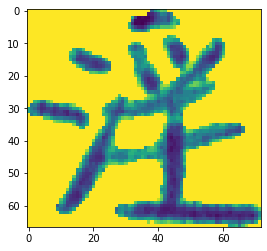

In [48]:
plt.imshow(test[185])

In [49]:
target2idx[63954]

301

c:\users\аким\appdata\local\programs\python\python37\lib\site-packages\torchvision\transforms\functional_tensor.py:876: UserWarning: Argument fill/fillcolor is not supported for Tensor input. Fill value is zero
  warnings.warn("Argument fill/fillcolor is not supported for Tensor input. Fill value is zero")


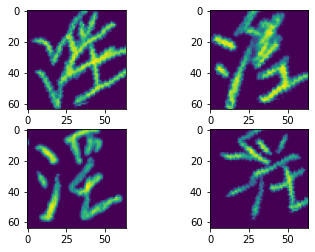

In [50]:
flag = 1
for data in train_loader:
    if flag == 5:
        break
    for i in range(len(data['y'])):
        if flag == 5:
            break
        if data['y'][i] == 301:
            plt.subplot(2, 2, flag)
            plt.imshow(data['x'][i][0])
            flag += 1
plt.show()